<a href="https://colab.research.google.com/github/shirishbahirat/artificial-intelligence/blob/master/Copy_of_reinforcement_learning_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd


class Catch(object):
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    def _update_state(self, action):
        """
        Input: action and states
        Ouput: new states and reward
        """
        state = self.state
        if action == 0:  # left
            action = -1
        elif action == 1:  # stay
            action = 0
        else:
            action = 1  # right
        f0, f1, basket = state[0]
        new_basket = min(max(1, basket + action), self.grid_size-1)
        f0 += 1
        out = np.asarray([f0, f1, new_basket])
        out = out[np.newaxis]

        assert len(out.shape) == 2
        self.state = out

    def _draw_state(self):
        im_size = (self.grid_size,)*2
        state = self.state[0]
        canvas = np.zeros(im_size)
        canvas[state[0], state[1]] = 1  # draw fruit
        canvas[-1, state[2]-1:state[2] + 2] = 1  # draw basket
        return canvas

    def _get_reward(self):
        fruit_row, fruit_col, basket = self.state[0]
        if fruit_row == self.grid_size-1:
            if abs(fruit_col - basket) <= 1:
                return 1
            else:
                return -1
        else:
            return 0

    def _is_over(self):
        if self.state[0, 0] == self.grid_size-1:
            return True
        else:
            return False

    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.observe(), reward, game_over

    def reset(self):
        n = np.random.randint(0, self.grid_size-1, size=1)
        m = np.random.randint(1, self.grid_size-2, size=1)
        self.state = np.asarray([0, n, m])[np.newaxis]


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        # memory[i] = [[state_t, action_t, reward_t, state_t+1], game_over?]
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1]
        env_dim = self.memory[0][0][0].shape[1]
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        targets = np.zeros((inputs.shape[0], num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory,
                                                  size=inputs.shape[0])):
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            game_over = self.memory[idx][1]

            inputs[i:i+1] = state_t
            # There should be no target values for actions not taken.
            # Thou shalt not correct actions not taken #deep
            targets[i] = model.predict(state_t)[0]
            Q_sa = np.max(model.predict(state_tp1)[0])
            if game_over:  # if game_over is True
                targets[i, action_t] = reward_t
            else:
                # reward_t + gamma * max_a' Q(s', a')
                targets[i, action_t] = reward_t + self.discount * Q_sa
        return inputs, targets


if __name__ == "__main__":
    # parameters
    epsilon = .1  # exploration
    num_actions = 3  # [move_left, stay, move_right]
    epoch = 1000
    max_memory = 500
    hidden_size = 100
    batch_size = 50
    grid_size = 10

    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(sgd(lr=.2), "mse")

    # If you want to continue training from a previous model, just uncomment the line bellow
    # model.load_weights("model.h5")

    # Define environment/game
    env = Catch(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)

    # Train
    win_cnt = 0
    for e in range(epoch):
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        input_t = env.observe()

        while not game_over:
            input_tm1 = input_t
            # get next action
            if np.random.rand() <= epsilon:
                action = np.random.randint(0, num_actions, size=1)
            else:
                q = model.predict(input_tm1)
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)
            if reward == 1:
                win_cnt += 1

            # store experience
            exp_replay.remember([input_tm1, action, reward, input_t], game_over)

            # adapt model
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

            loss += model.train_on_batch(inputs, targets)
        print("Epoch {:03d}/999 | Loss {:.4f} | Win count {}".format(e, loss, win_cnt))

    # Save trained model weights and architecture, this will be used by the visualization code
    model.save_weights("model.h5", overwrite=True)
    with open("model.json", "w") as outfile:
        json.dump(model.to_json(), outfile)

Using TensorFlow backend.


Epoch 000/999 | Loss 0.0428 | Win count 1
Epoch 001/999 | Loss 0.1621 | Win count 1
Epoch 002/999 | Loss 0.1569 | Win count 1
Epoch 003/999 | Loss 0.2843 | Win count 1
Epoch 004/999 | Loss 0.3078 | Win count 1
Epoch 005/999 | Loss 0.2878 | Win count 2
Epoch 006/999 | Loss 0.1913 | Win count 2
Epoch 007/999 | Loss 0.2502 | Win count 3
Epoch 008/999 | Loss 0.1976 | Win count 4
Epoch 009/999 | Loss 0.1979 | Win count 4
Epoch 010/999 | Loss 0.2803 | Win count 4
Epoch 011/999 | Loss 0.1675 | Win count 5
Epoch 012/999 | Loss 0.2298 | Win count 5
Epoch 013/999 | Loss 0.2205 | Win count 6
Epoch 014/999 | Loss 0.2377 | Win count 7
Epoch 015/999 | Loss 0.2200 | Win count 7
Epoch 016/999 | Loss 0.2419 | Win count 8
Epoch 017/999 | Loss 0.2491 | Win count 8
Epoch 018/999 | Loss 0.2321 | Win count 9
Epoch 019/999 | Loss 0.1822 | Win count 9
Epoch 020/999 | Loss 0.2359 | Win count 10
Epoch 021/999 | Loss 0.2502 | Win count 10
Epoch 022/999 | Loss 0.2430 | Win count 11
Epoch 023/999 | Loss 0.2009 | W

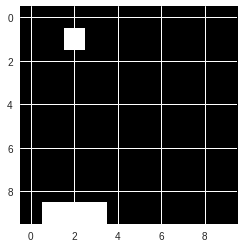

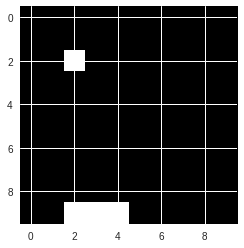

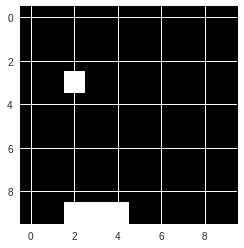

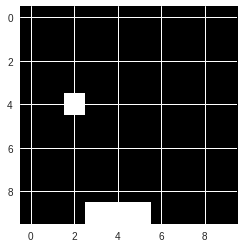

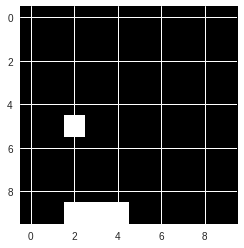

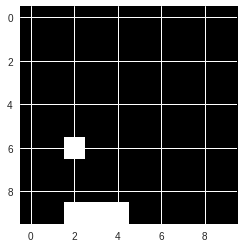

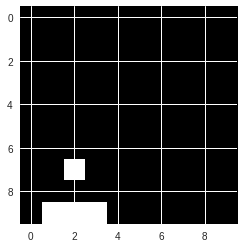

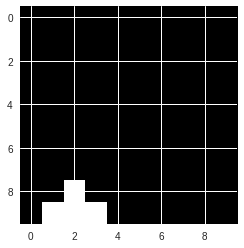

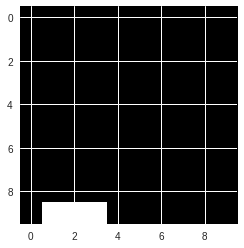

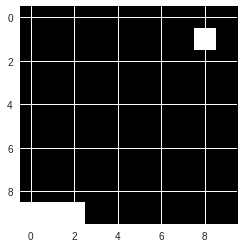

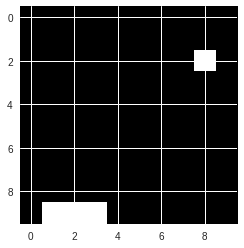

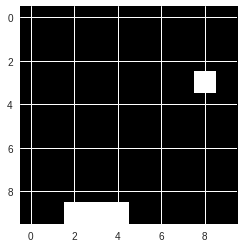

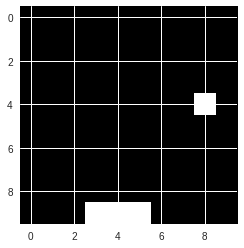

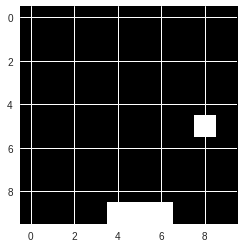

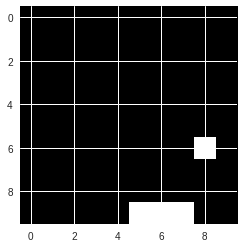

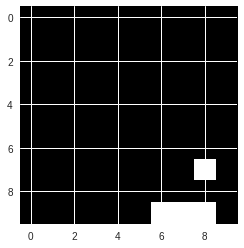

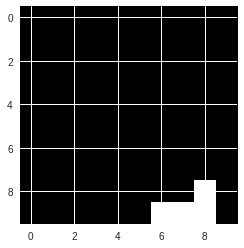

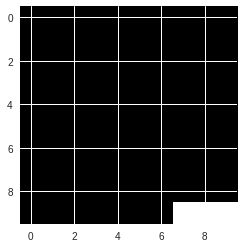

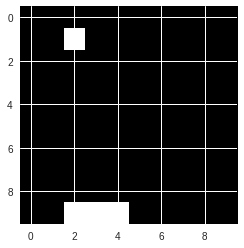

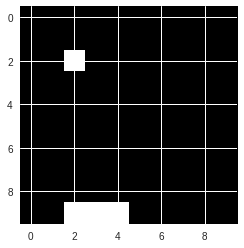

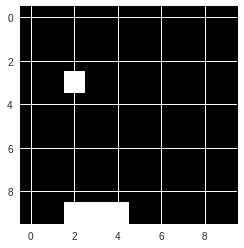

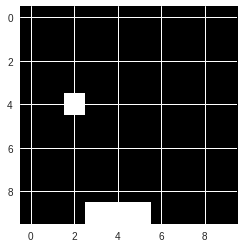

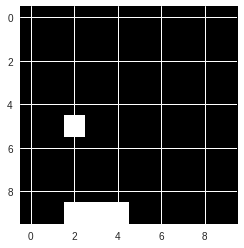

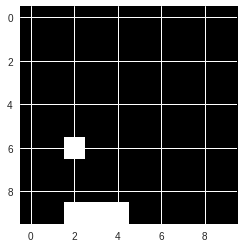

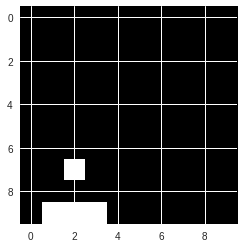

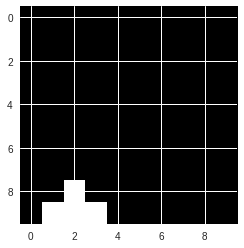

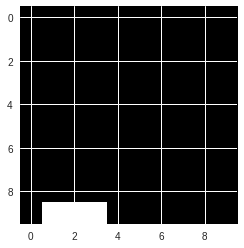

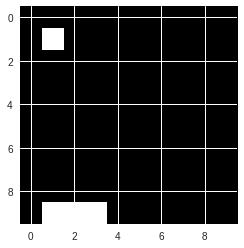

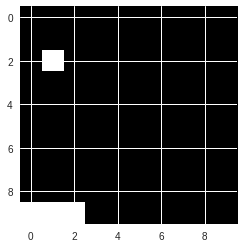

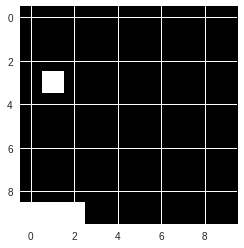

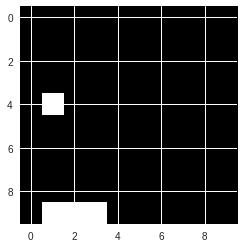

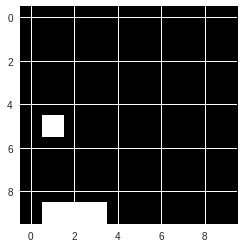

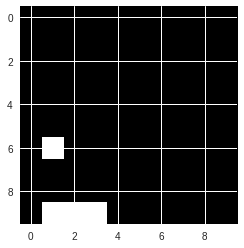

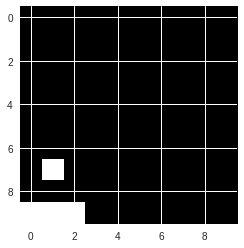

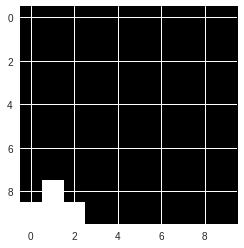

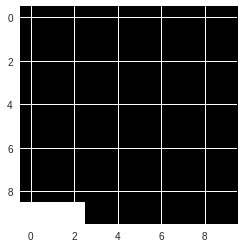

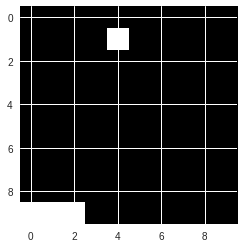

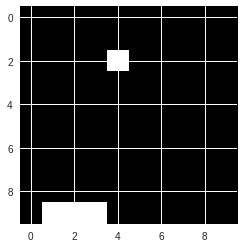

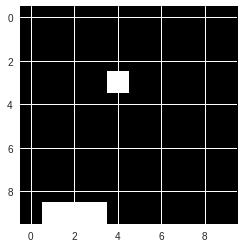

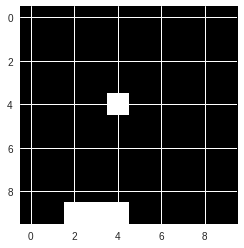

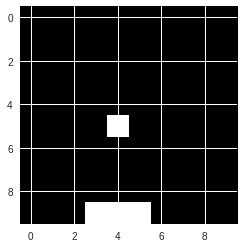

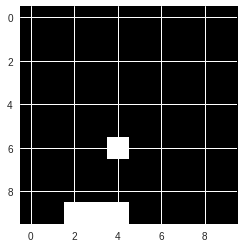

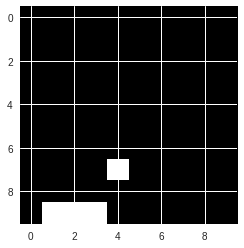

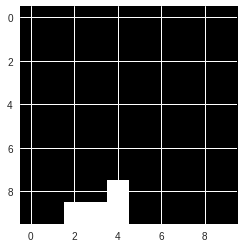

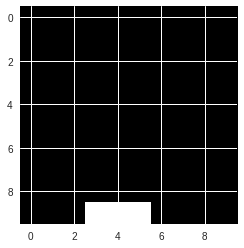

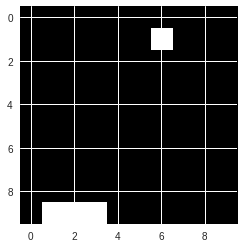

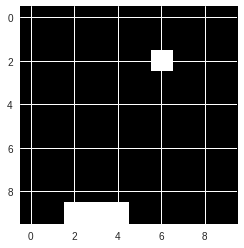

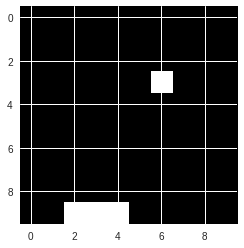

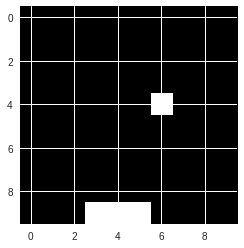

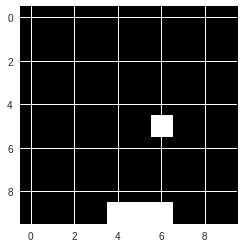

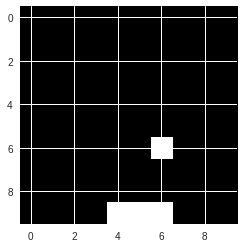

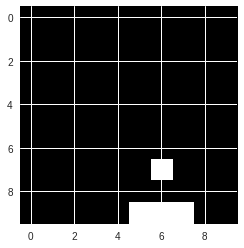

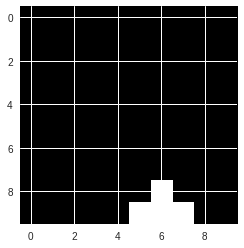

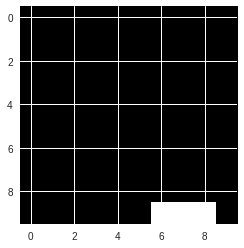

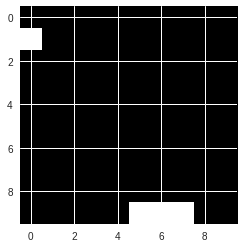

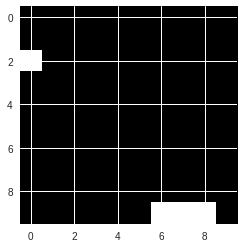

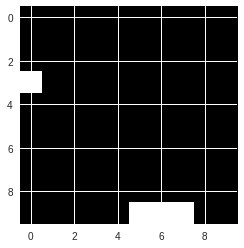

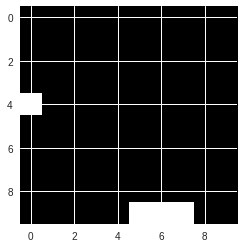

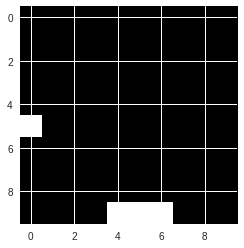

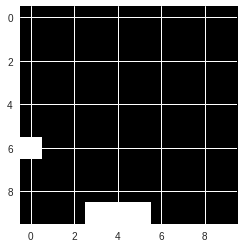

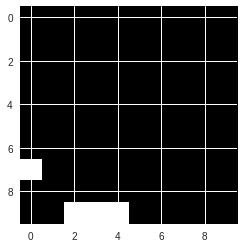

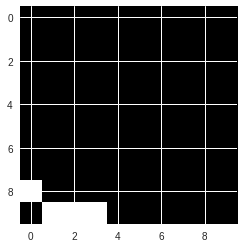

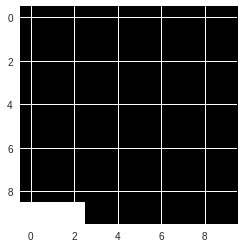

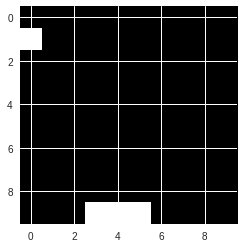

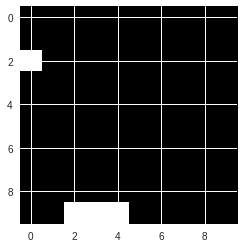

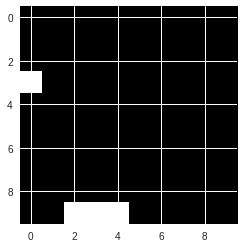

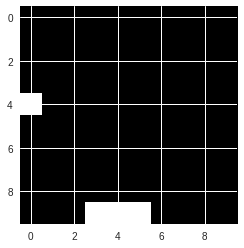

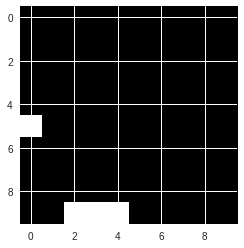

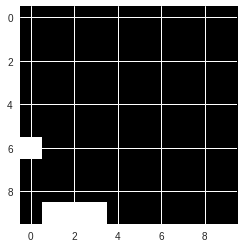

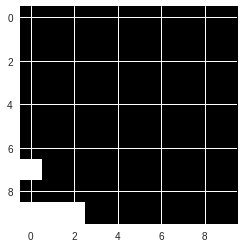

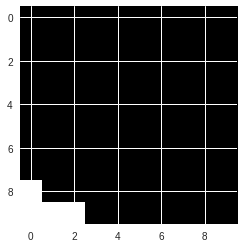

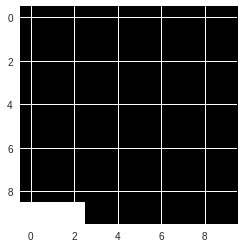

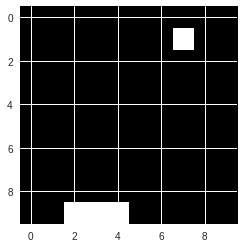

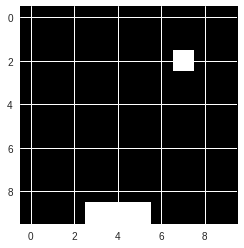

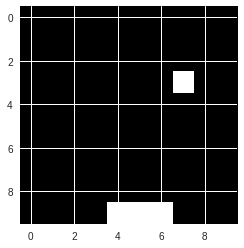

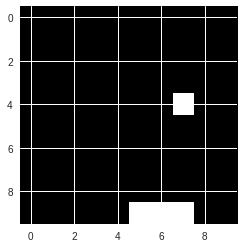

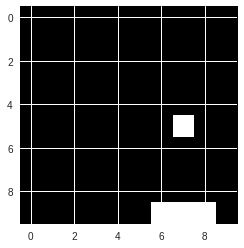

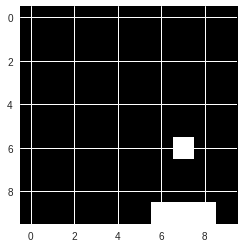

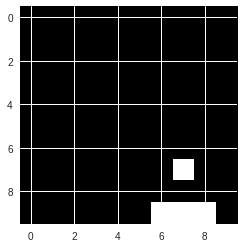

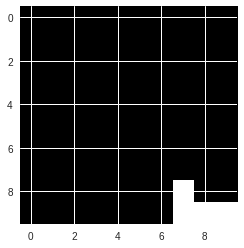

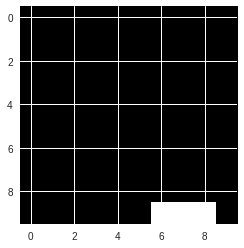

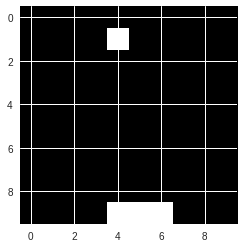

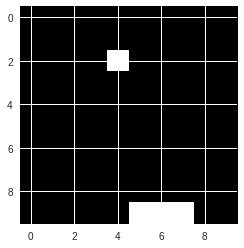

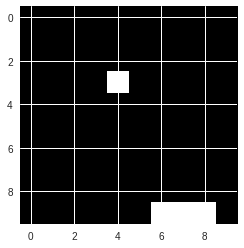

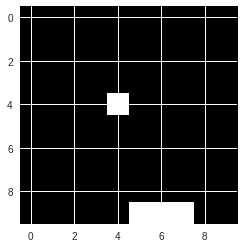

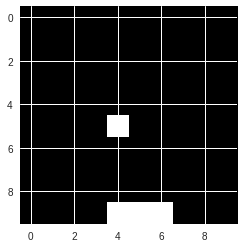

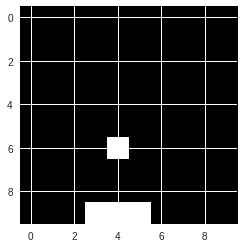

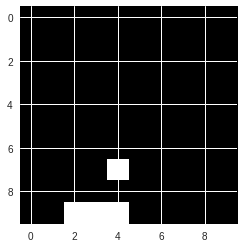

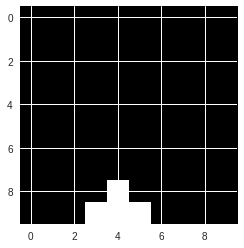

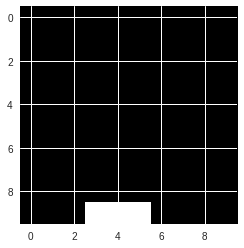

In [9]:
%matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
from keras.models import model_from_json


if __name__ == "__main__":
    # Make sure this grid size matches the value used fro training
    grid_size = 10

    with open("model.json", "r") as jfile:
        model = model_from_json(json.load(jfile))
    model.load_weights("model.h5")
    model.compile("sgd", "mse")

    # Define environment, game
    env = Catch(grid_size)
    c = 0
    for e in range(10):
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        input_t = env.observe()

        plt.imshow(input_t.reshape((grid_size,)*2),
                   interpolation='none', cmap='gray')
        plt.savefig("%03d.png" % c)
        c += 1
        while not game_over:
            input_tm1 = input_t

            # get next action
            q = model.predict(input_tm1)
            action = np.argmax(q[0])

            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)

            plt.imshow(input_t.reshape((grid_size,)*2),
                       interpolation='none', cmap='gray')
            plt.savefig("%03d.png" % c)
            plt.show()
            plt.pause(0.0001)
            plt.close()
            c += 1